In [1]:
import osmnx as ox
import networkx as nx
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
import pickle
import time
random.seed(42)
torch.manual_seed(42)

In [2]:
G = ox.graph_from_place("Lviv Oblast, Ukraine", network_type='drive')
G = ox.utils_graph.get_undirected(G)
nodes, edges = ox.graph_to_gdfs(G)
node_ids = list(G.nodes)
node_id_map = {nid: i for i, nid in enumerate(node_ids)}
inv_node_id_map = {i: nid for nid, i in node_id_map.items()}

C:\Users\Ryzen\AppData\Local\Temp\ipykernel_20876\2555253236.py:2: FutureWarning: The `get_undirected` function is deprecated and will be removed in the v2.0.0 release. Replace it with `convert.to_undirected` instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  G = ox.utils_graph.get_undirected(G)


In [3]:
coords = np.array([[G.nodes[n]['x'], G.nodes[n]['y']] for n in node_ids])
scaler = StandardScaler()
coords_scaled = scaler.fit_transform(coords)
features = torch.tensor(coords_scaled, dtype=torch.float)

In [4]:
edge_index = []
for u, v in G.edges():
    if u in node_id_map and v in node_id_map:
        edge_index.append((node_id_map[u], node_id_map[v]))
        edge_index.append((node_id_map[v], node_id_map[u]))
edge_index = torch.tensor(edge_index).t()

def get_nearest_node(lat, lon):
    return ox.distance.nearest_nodes(G, lon, lat)

map_points=[(49.80611220996008, 23.97955612862654),
(49.80532285209437, 23.98237781261442),
(49.80478275771747, 23.987291619711186),
(49.8042495817099, 23.99243073217024),
(49.80390336037501, 23.996432588052162),
(49.80395183150313, 23.999769256034998),
(49.80649303590949, 23.999114796958104),
(49.81293216592172, 24.000763128745433),
(49.81766865049101, 24.003570346218133),
(49.823736810282, 24.00771312858426),
(49.82582162024907, 24.00966317414233),
(49.832640701340466, 24.01859487887445),
(49.83680583050842, 24.02202637853643),
(49.840145382636926, 24.027186953530506),
(49.84012073274527, 24.028125056144603),
(49.839253501750214, 24.03253064738627)]

def route_creator(destinations):
    random_long_route=[]
    for i in range(destinations):
        coordinate_number = random.randrange(0, len(map_points))
        destination = map_points[coordinate_number]
        random_long_route.append(destination)
    return random_long_route

map_points_nodes = [node_id_map[get_nearest_node(lat, lon)] for lat, lon in map_points]

In [5]:
class PathWalkGNN(nn.Module):
    def __init__(self, in_feats, hidden_dim):
        super(PathWalkGNN, self).__init__()
        self.fc1 = nn.Linear(in_feats * 2, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, current_node_feat, neighbor_feats):
        n = neighbor_feats.size(0)
        current = current_node_feat.expand(n, -1)
        x = torch.cat([current, neighbor_feats], dim=1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x).squeeze()
        return x

model = PathWalkGNN(in_feats=2, hidden_dim=64)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

def train(model, route, features, edge_index, epochs=50):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        pbar = tqdm(range(len(route)-1), desc=f"Epoch {epoch+1}/{epochs}")
        for i in pbar:
            src = route[i]
            tgt = route[i+1]
            neighbors = [v.item() for v in edge_index[1][edge_index[0] == src]]

            if tgt not in neighbors:
                continue

            current_feat = features[src]
            neighbor_feats = features[neighbors]
            logits = model(current_feat, neighbor_feats)
            labels = torch.tensor(neighbors.index(tgt))
            loss = criterion(logits.unsqueeze(0), labels.unsqueeze(0))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            pbar.set_postfix(loss=loss.item())
        print(f"Epoch {epoch+1} loss: {total_loss:.4f}")
        torch.save(model.state_dict(), "pathwalk_gnn.pth")
        with open("scaler.pkl", "wb") as f:
            pickle.dump(scaler, f)

def generate_path(model, start_id, target_id, max_steps=50):
    model.eval()
    path = [start_id]
    for _ in range(max_steps):
        current = path[-1]
        neighbors = [v.item() for v in edge_index[1][edge_index[0] == current]]
        if not neighbors:
            break
        current_feat = features[current]
        neighbor_feats = features[neighbors]
        with torch.no_grad():
            scores = model(current_feat, neighbor_feats)
        next_node = neighbors[torch.argmax(scores).item()]
        if next_node in path:
            break
        path.append(next_node)
        if next_node == target_id:
            break
    return [inv_node_id_map[n] for n in path]

def generate_full_path(model, route_nodes):
    model.eval()
    path = []
    for i in range(len(route_nodes) - 1):
        current = route_nodes[i]
        target = route_nodes[i+1]

        sub_path = [current]
        for _ in range(30):
            neighbors = [v.item() for v in edge_index[1][edge_index[0] == current]]
            if not neighbors:
                break
            current_feat = features[current]
            neighbor_feats = features[neighbors]
            with torch.no_grad():
                scores = model(current_feat, neighbor_feats)
            next_node = neighbors[torch.argmax(scores).item()]
            if next_node in sub_path:
                break
            sub_path.append(next_node)
            current = next_node
            if current == target:
                break

        if not path:
            path.extend(sub_path)
        else:
            path.extend(sub_path[1:])
    return [inv_node_id_map[n] for n in path]

#train(model, map_points_nodes, features, edge_index)

model.load_state_dict(torch.load("pathwalk_gnn.pth"))
with open("scaler.pkl", "rb") as f:
    scaler = pickle.load(f)


In [14]:
print(model)

PathWalkGNN(
  (fc1): Linear(in_features=4, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)


In [6]:
stops = [2,4,8,16,64]
for i in range(len(stops)):
    target_route = route_creator(stops[i])
    print(len(target_route))
    timer_start = time.time()

    target_route_nodes = [node_id_map[get_nearest_node(lat, lon)] for lat, lon in target_route]
    
    gen_path = generate_full_path(model, target_route_nodes)
    
    timer_end = time.time()
    time_total = timer_end - timer_start
    print("time to generate route: " + str(time_total) + " s")

2
time to generate route: 0.432157039642334 s
4
time to generate route: 0.8550376892089844 s
8
time to generate route: 1.7074453830718994 s
16
time to generate route: 3.7981584072113037 s
64
time to generate route: 13.621859073638916 s


In [12]:
target_route = route_creator(2)
target_route_nodes = [node_id_map[get_nearest_node(lat, lon)] for lat, lon in target_route]
gen_path = generate_full_path(model, target_route_nodes)

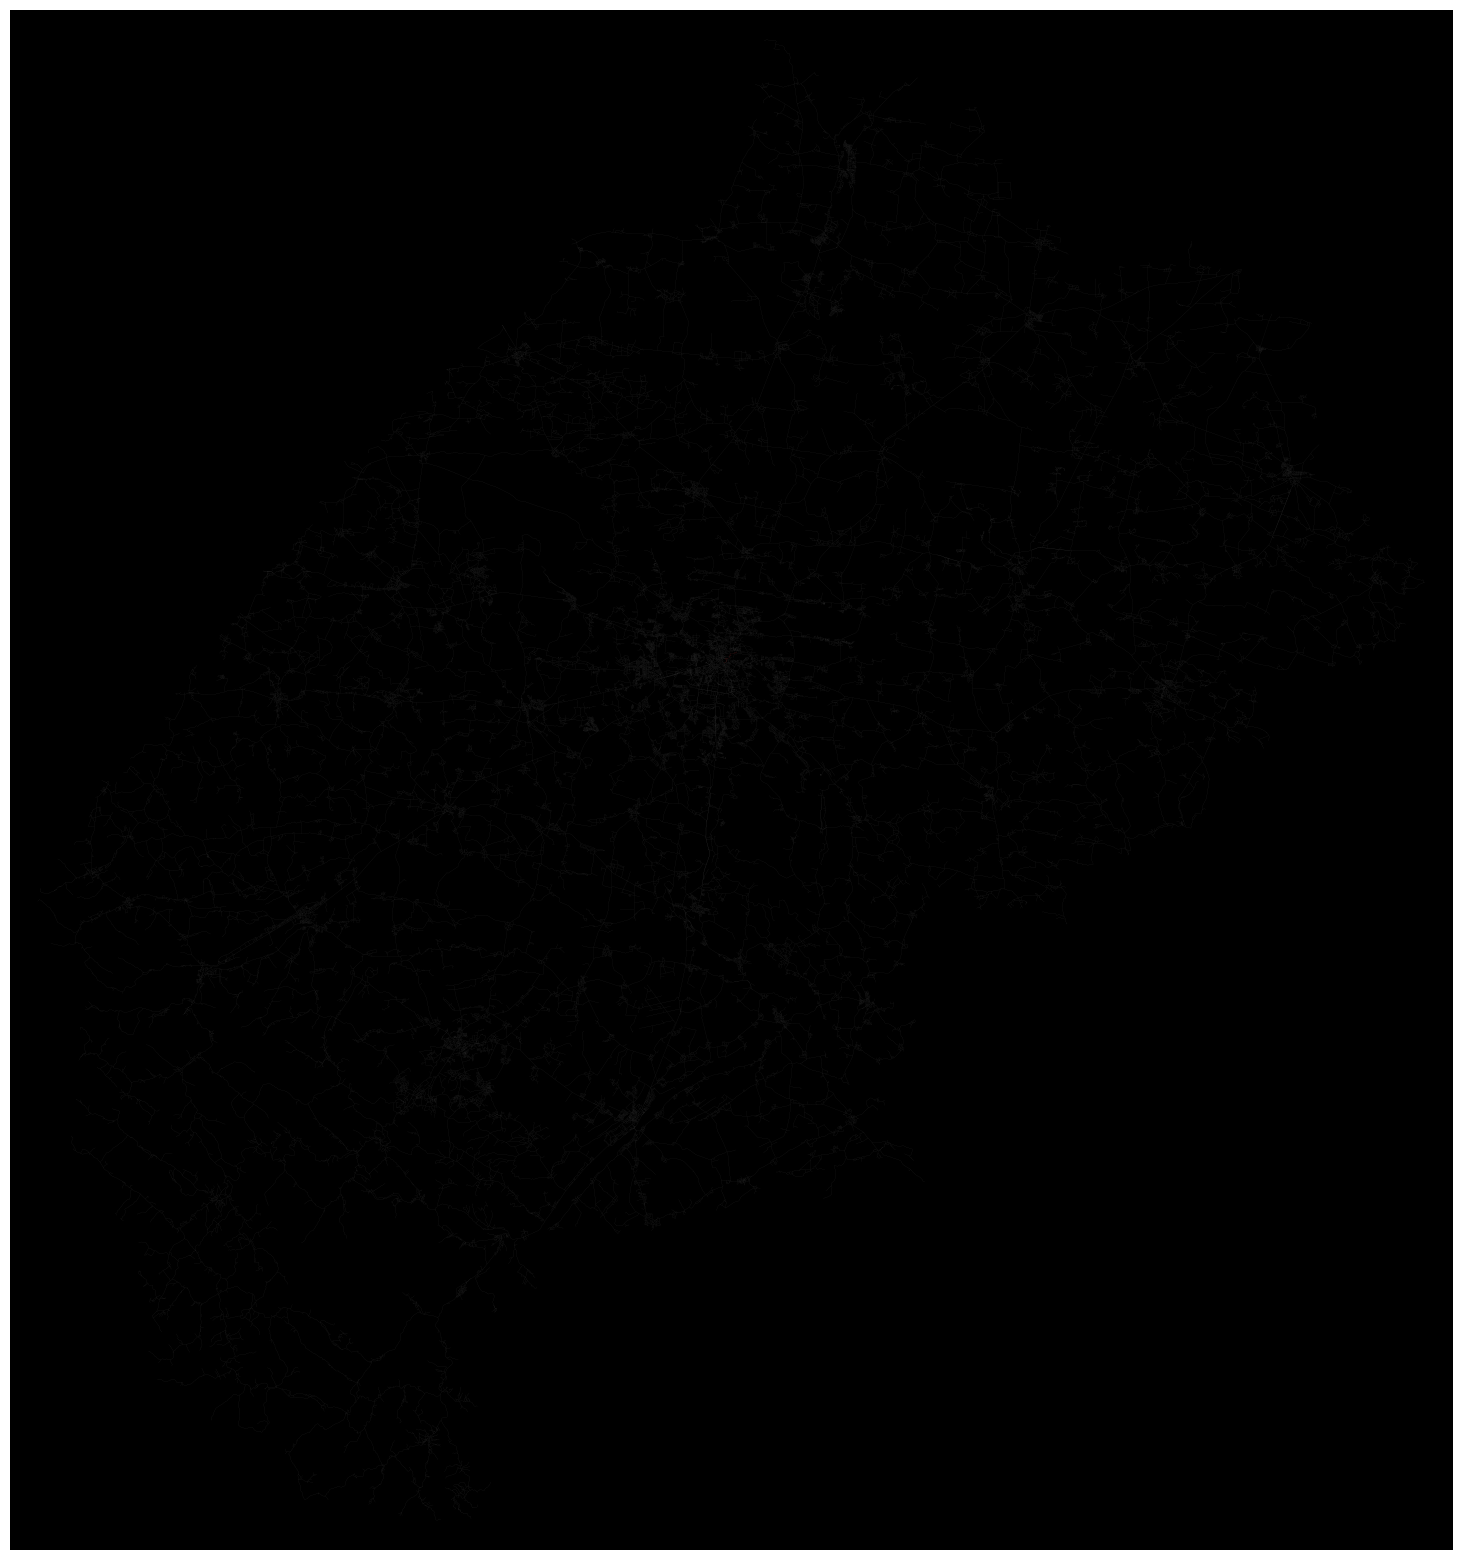

In [13]:
target_route = route_creator(64)
target_route_nodes = [node_id_map[get_nearest_node(lat, lon)] for lat, lon in target_route]
gen_path = generate_full_path(model, target_route_nodes)

fig, ax = ox.plot_graph_route(
        G, gen_path,
        figsize=(20, 20),
        node_size=0,
        edge_linewidth=0.02,
        bgcolor='black',
        edge_color="white",
        route_linewidth=0.02,
        route_alpha=1,
        orig_dest_size=0.03
    )

In [25]:
#fig.savefig('GNN_Route.png', format='png', dpi=2000, bbox_inches='tight')